## 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : 캐글 대회 Bike Sharing Demand 데이터를 활용한 수요 예측 대회
- 프로젝트 마감일 : 2022년 7월 19일 화요일
- 수강생명 : 채제형

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


## STEP 1. 필수 라이브러리 불러오기

In [2]:
import pandas as pd # 데이터 가공
import numpy as np # 수치 연산
import matplotlib as mpl # 시각화 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns # 시각화 
import sklearn # 머신러닝

# 버전 확인
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)

pandas version : 1.3.5
numpy version : 1.21.6


## STEP 2. 데이터 불러오기

In [3]:
DATA_PATH = '/kaggle/input/bike-sharing-demand/'
train = pd.read_csv(DATA_PATH +'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sampleSubmission.csv')

print("데이터 불러오기 완료!~")

데이터 불러오기 완료!~


## STEP 3.데이터 둘러보기

In [4]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [5]:
train.info() # 12개의 변수

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
target = train['count'] # 타겟변수 확인

In [8]:
sum(train.duplicated())# 데이터 중복은 없어보인다.

0

In [9]:
train.isnull().sum()# 결측치는 없어 보인다.

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# 변수의 내용을 파악해 보면
- datetime     시간별 날자(->수치화 시킬 필요가 있다)
- season       계절 :봄(1)여름(2)가을(3)겨울(4)
- holiday       휴일
- workingday    평일 -> 평일도 휴일도 아닌 날이 존재하게 된다.이를 주말로 정의하자. 
- weather       날씨 : 맑음(1),흐림(2),작은비(3),폭우(4)
- temp          (섭씨)온도
- atemp         체감온도
- humidity      (상대)습도
- windspeed     풍속
- casual        미등록 사용자 대여수
- registered    등록된 사용자 대여수
- count         총대여수(미등록자+등록자)

In [10]:
# 비회원(casual)과 회원(registered)의 대여량의 비율을 확인해본다.
print('미등록자수의 비율:',round((train['casual'].sum()/train['count'].sum())*100,2))
print('등록자수의 비율:',round((train['registered'].sum()/train['count'].sum())*100,2))

미등록자수의 비율: 18.8
등록자수의 비율: 81.2


## STEP 4. 탐색적 자료 분석
- 복제본 사용
  + 시간변수를 수치형 변수로 변환
 
- 시각화
  + 타겟 변수의 상태 확인
  + 수치형 변수와 대여량 간의 관계(온도,체감온도,습도,풍속)
  + 범주형 변수와 대여량 간의 관계(시간,날씨,계절,일하는날,휴일)
 

In [11]:
temp_train = train.copy()
temp_test = test.copy()
temp_target = target.copy()# 복제본 완료
temp_train.shape, temp_test.shape, temp_target.shape

((10886, 12), (6493, 9), (10886,))

In [12]:
# 시간관련 변수를 수치형 변수로 바꿔준다.
temp_train['date'] = pd.to_datetime(temp_train['datetime'])
temp_train['year'] = temp_train['date'].dt.year
temp_train['month'] = temp_train['date'].dt.month
temp_train['day'] = temp_train['date'].dt.day
temp_train['hour'] = temp_train['date'].dt.hour
#분과 초는 0값이기에 필요가 없어서 생략함
temp_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4


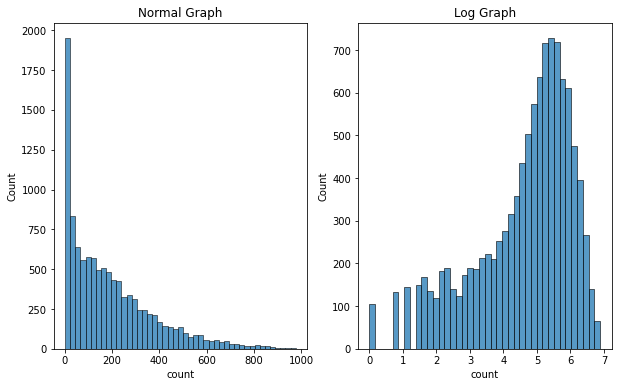

In [13]:
# 타겟변수(총대여수)를 확인하여 시각화를 해봤다
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (10,6))
sns.histplot(temp_train['count'],ax = ax[0])
sns.histplot(np.log(temp_train['count']),ax = ax[1])

ax[0].set_title('Normal Graph')
ax[1].set_title('Log Graph')

plt.show()

-> 시각화 결과 왼쪽으로 치우쳐졌기에 로그함수를 이용 정규분포와 비슷하게 만들었다.

### 1.수치형 변수와 대여량 간의 관계
   + 온도,체감온도,습도,풍속은 연속형 변수로 총대여수와의 관계를 살펴보기 위해 상관계수 히트맵 그래프를 그려본다.

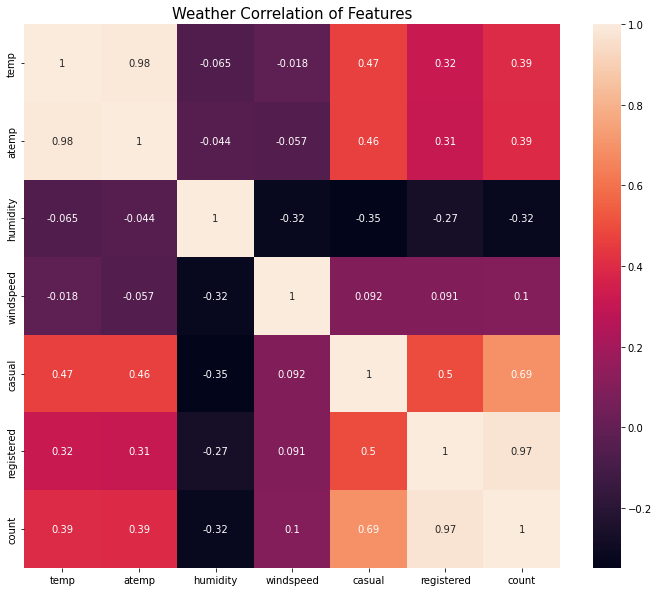

In [14]:
plt.figure(figsize=(12,10))
plt.title("Weather Correlation of Features",y= 1, size = 15)
coorMat = temp_train[['temp','atemp','humidity','windspeed','casual','registered','count']].corr()
sns.heatmap(coorMat, annot = True)
plt.show()

- 총대여수(count)와 상관성을 갖는 값을 나열해보면 온도 및 체감온도(0.39)>습도(-0.32)>풍속(0.1)이였다. 이는 온도 및 체감온도는 총대여수와 정비례하고 습도는 반비례 풍속은 미미한 정비례 관계이다.
   + 온도와 체감온도는 중복이 된다고 할 수 있다.둘 중 하나는 생략하자.
- casual과 registered가 온도,습도에서 차이가 나는 것은 아마도 casual(비회원)이 날씨에 더 민감함을 알 수 있다.
- 온도, 체감온도, 습도, 풍속의 산점도와 회귀선을 그려 더 구체화 시켜보자.

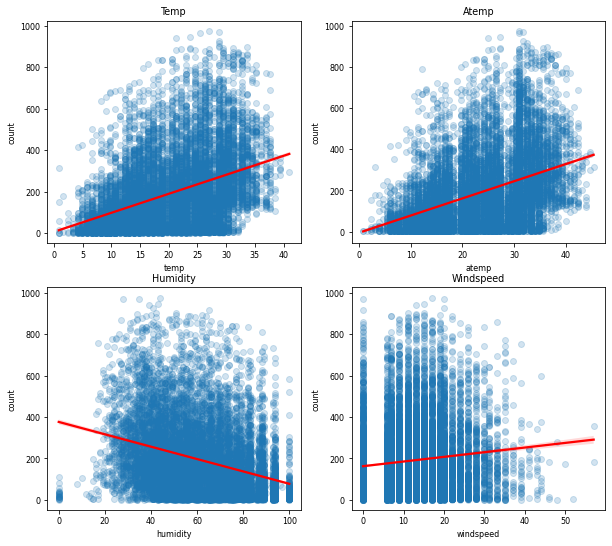

In [15]:
# 산점도 플렛
plt. rc('font',size =8)
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize= (10,9))

# 2단계 : 각 개별 그래프 입력
sns.regplot(x = 'temp', y = 'count', data = temp_train, scatter_kws = {'alpha':0.2}, line_kws = {'color':'red'},ax=ax[0,0])
sns.regplot(x = 'atemp',y = 'count', data = temp_train,scatter_kws = {'alpha':0.2}, line_kws = {'color':'red'}, ax=ax[0,1])
sns.regplot(x = 'humidity', y = 'count', data = temp_train,scatter_kws = {'alpha':0.2}, line_kws = {'color':'red'}, ax=ax[1,0])
sns.regplot(x = 'windspeed', y = 'count', data = temp_train, scatter_kws = {'alpha':0.2}, line_kws = {'color':'red'},ax=ax[1,1])

# 3단계 : 디테일 옵션
ax[0, 0].set_title("Temp")
ax[0, 1].set_title("Atemp")
ax[1, 0].set_title("Humidity")
ax[1, 1].set_title("Windspeed")


plt.show()

- windspeed에서 풍속이 0인 수치가 많고 약 6까지 수치가 없는 것으로 봐서 6이하를 0으로 표시한 것 같다.
 + 풍속이 0인 수치를 평균값으로 대체하도록 하자.

<AxesSubplot:xlabel='windspeed', ylabel='count'>

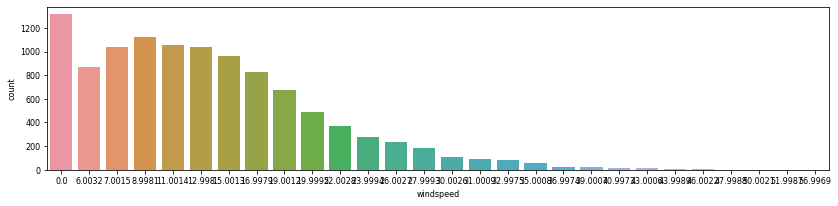

In [16]:
plt.figure(figsize=(14,3))
sns.countplot(data = temp_train, x = "windspeed") # 윈드스피드의 수치 확인

### 2.범주형 변수와 총대여수와의 관계
  + 시간(year,month,day,hour)
  + 날씨(weather)
  + 계절(season)
  + 평일(workingday), 휴일(holiday)
 를 시각화하자(그래프로 그려보자).


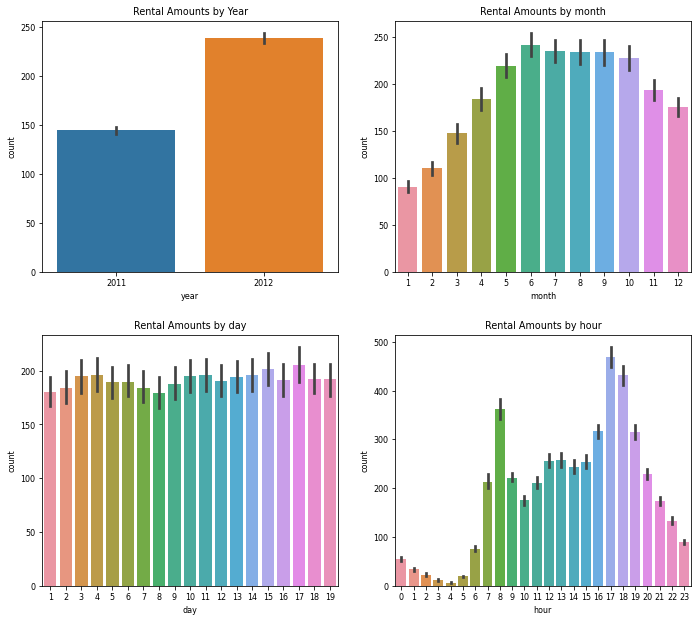

In [17]:
# 시간과 관련 그래프를 그려보자.
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.tight_layout()
fig.set_size_inches(10, 9)
sns.barplot(x = 'year', y = 'count', data = temp_train, ax=ax[0,0])
sns.barplot(x = 'month',y = 'count', data = temp_train, ax=ax[0,1])
sns.barplot(x = 'day', y = 'count', data = temp_train, ax=ax[1,0])
sns.barplot(x = 'hour', y = 'count', data = temp_train, ax=ax[1,1])

ax[0, 0].set_title("Rental Amounts by Year")
ax[0, 1].set_title("Rental Amounts by month")
ax[1, 0].set_title("Rental Amounts by day")
ax[1, 1].set_title("Rental Amounts by hour")

plt.show()

- 그래프를 해석해보면 2012년도가 전년에 비해 대여량이 늘었다
- 겨울보다는 여름에 더 대여량이 높다.
- 날짜별로는 특별한 차이가 없기에 데이터로서 가치가 없다(제거)
- 출퇴근 시간으로 보이는 오전 8시와 오후 5-6시에 대여량이 높다.

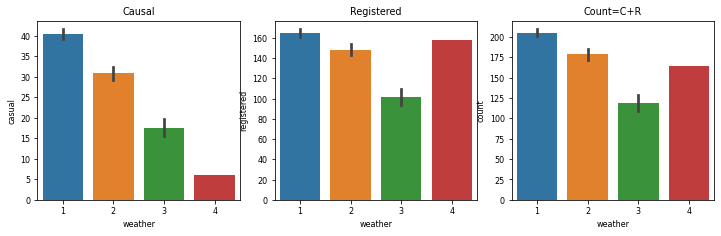

In [18]:
# 날씨 관련 그래프를 그려보자.
fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize=(10,3))
fig.tight_layout()
sns.barplot(x = 'weather', y = 'casual', data = temp_train, ax=ax[0])
sns.barplot(x = 'weather',y = 'registered', data = temp_train, ax=ax[1])
sns.barplot(x = 'weather', y = 'count', data = temp_train, ax=ax[2])

ax[0].set_title("Causal")
ax[1].set_title("Registered")
ax[2].set_title("Count=C+R")

plt.show()

그래프가 이상하다. 안좋은 날씨 데이터(4)는 적은데 높게 나와있다. 평균치로 나타냈기 때문일 것이다.
이를 해결하기 위해 y축을 합계로 계산해보자.

In [19]:
(temp_train.groupby('weather')[['datetime']].count()/len(temp_train))*100

,datetime
weather,
1,66.066507
2,26.033437
3,7.890869
4,0.009186


In [20]:
W_train = temp_train.groupby('weather')[['count']].sum().reset_index()
Wc_train = temp_train.groupby('weather')[['casual']].sum().reset_index()
Wr_train = temp_train.groupby('weather')[['registered']].sum().reset_index()

Text(0.5, 1.0, 'Count=C+R')

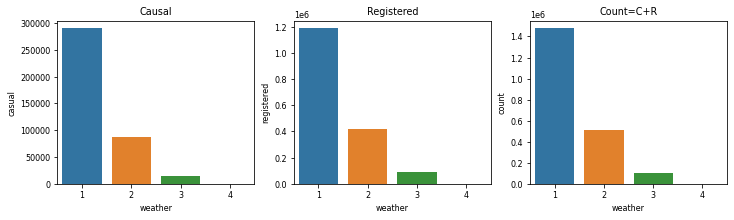

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize=(12,3))
# fig.tight_layout()
sns.barplot(x = 'weather', y = 'casual', data = Wc_train, ax=ax[0])
sns.barplot(x = 'weather',y = 'registered', data = Wr_train, ax=ax[1])
sns.barplot(x = 'weather', y = 'count', data = W_train, ax=ax[2])

ax[0].set_title("Causal")
ax[1].set_title("Registered")
ax[2].set_title("Count=C+R")


Text(0.5, 1.0, 'Count=C+R')

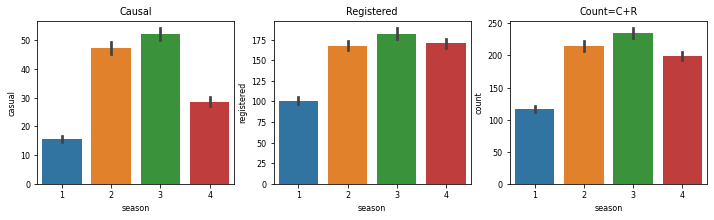

In [22]:
# 계절 관련 그래프를 그려보자
fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize=(12,3))

sns.barplot(x = 'season', y = 'casual', data = temp_train, ax=ax[0])
sns.barplot(x = 'season',y = 'registered', data = temp_train, ax=ax[1])
sns.barplot(x = 'season', y = 'count', data = temp_train, ax=ax[2])

ax[0].set_title("Causal")
ax[1].set_title("Registered")
ax[2].set_title("Count=C+R")


- season과 month는 비슷한 양상의 그래프이다. 실제로 month를 3개월 단위로 자른 것이기에 비슷한 변수가 머신러닝 모델에 중복해서 들어가면 예측 성는이 안 좋아지므로 변수 season은 생략하는 것이 좋겠다.

In [23]:
# workingday와 holyday를 그래프로 그려보자
# 여기서 workingday는 평일 holyday는 공휴일로 봤을 때 둘다 아닌 날은 주말(weekend)로 정의한다.
temp_train['day_type'] = 'weekend'
is_holi = (train['holiday'] == 1)
is_week = (train['workingday'] == 1)

temp_train.loc[(is_holi),'day_type'] = 'holiday'
temp_train.loc[(is_week),'day_type'] = 'workingday'
work_holi = (temp_train.groupby('day_type')[['casual','registered','count']].sum()/
             temp_train.groupby('day_type')[['casual','registered','count']].count())
temp_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,day_type
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,0,weekend
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,1,weekend
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,2,weekend
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,3,weekend
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,4,weekend


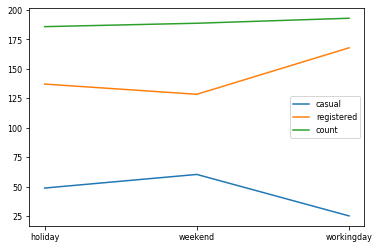

In [24]:
#시각화
plt.plot(work_holi)
plt.legend(work_holi.columns)
plt.show()

- 사용량은 등록자 대여수(registered)가 비등록자 대여수(casual)보다 많다. 평일(workingday)에 등록자 대여수가 가장 높고 비등록자 대여수가 적은 것을 볼 수 있다.

In [25]:
# 데이터 나누기
h1 = temp_train.loc[temp_train['day_type'] == 'workingday']
h2 = temp_train.loc[temp_train['day_type'] == 'weekend']
h3 = temp_train.loc[temp_train['day_type'] == 'holiday']

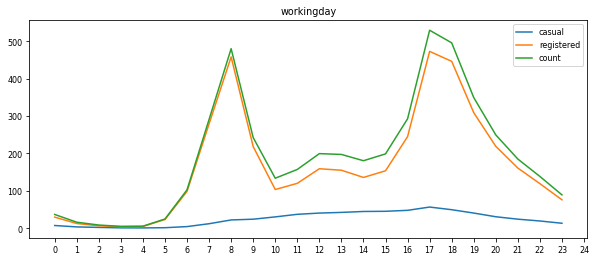

In [26]:
# 평일에 대해 -시간대별 평균대여량
h1_df = h1.groupby('hour')[['casual','registered','count']].mean()

plt.figure(figsize=(10,4))
plt.plot(h1_df)
plt.xticks(np.arange(0,25))
plt.legend(h1_df.columns)
plt.title('workingday')
plt.show()

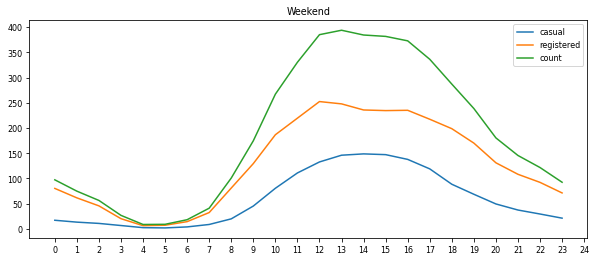

In [27]:
# 주말에 대해 -시간대별 평균대여량
h2_df = h2.groupby('hour')[['casual','registered','count']].mean()

plt.figure(figsize=(10,4))
plt.plot(h2_df)
plt.xticks(np.arange(0,25))
plt.legend(h2_df.columns)
plt.title('Weekend')
plt.show()

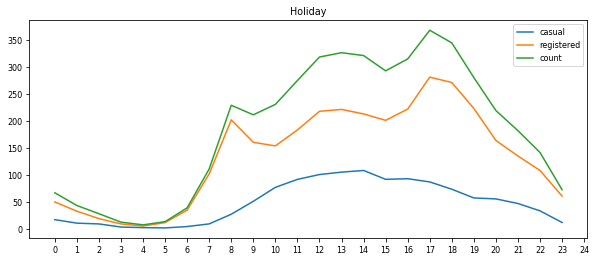

In [28]:
# 공휴일에 대해 -시간대별 평균대여량
h3_df = h3.groupby('hour')[['casual','registered','count']].mean()

plt.figure(figsize=(10,4))
plt.plot(h3_df)
plt.xticks(np.arange(0,25))
plt.legend(h3_df.columns)
plt.title('Holiday')
plt.show()

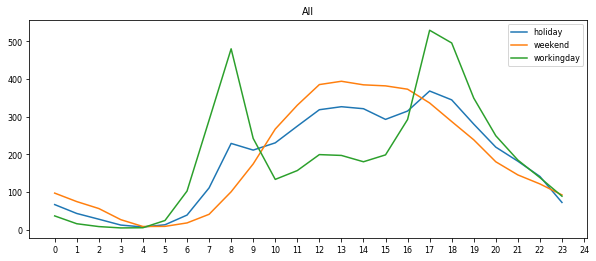

In [29]:
# 모든 그래프를 한번에 보면
h_all = temp_train.pivot_table(index ='hour',columns = 'day_type', values = 'count', aggfunc='mean')
plt.figure(figsize=(10,4))
plt.plot(h_all)
plt.xticks(np.arange(0,25))
plt.legend(h_all.columns)
plt.title('All')
plt.show()

- 평일에는 출퇴근 시간인 오전 8시와 오후 5-6시에 많이 이용되고 주말과 공휴일에는 낮시간에 대다수 이용된다. 공휴일에는 놀러가는 사람이 많은지 출퇴근 시간만큼은 아니지만 많이 이용되는 시간대가 있다.

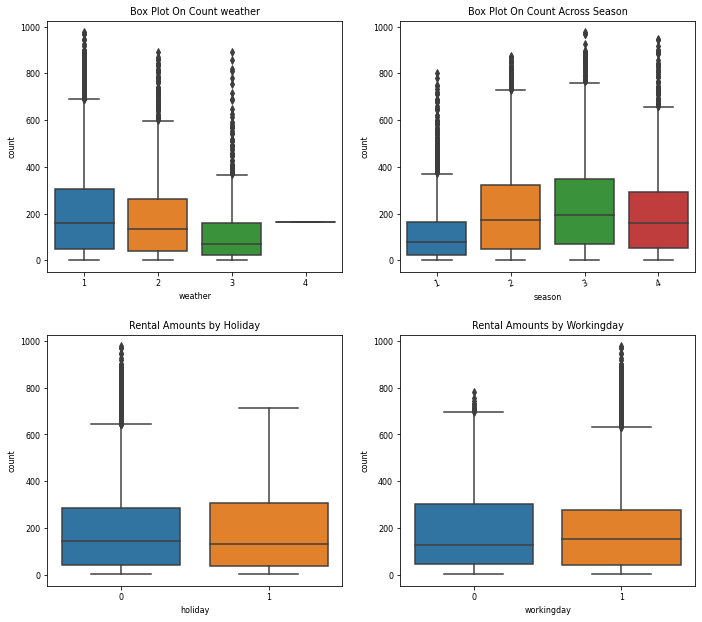

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.tight_layout()
fig.set_size_inches(10, 9)

sns.boxplot(x = 'weather', y = 'count', data = temp_train, ax=ax[0,0])
sns.boxplot(x = 'season',y = 'count', data = temp_train, ax=ax[0,1])
sns.boxplot(x = 'holiday', y = 'count', data = temp_train, ax=ax[1,0])
sns.boxplot(x = 'workingday', y = 'count', data = temp_train, ax=ax[1,1])

ax[0, 0].set_title("Box Plot On Count weather")
ax[0, 1].set_title("Box Plot On Count Across Season")
ax[1, 0].set_title("Rental Amounts by Holiday")
ax[1, 1].set_title("Rental Amounts by Workingday")

ax[0, 1].tick_params(axis = 'x', labelrotation=20)

plt.show()

- weather 데이터에서 4번은 반드시 처리해야 한다.

In [31]:
temp_train['weekday'] = temp_train['date'].dt.day_name() # 요일 추출하기

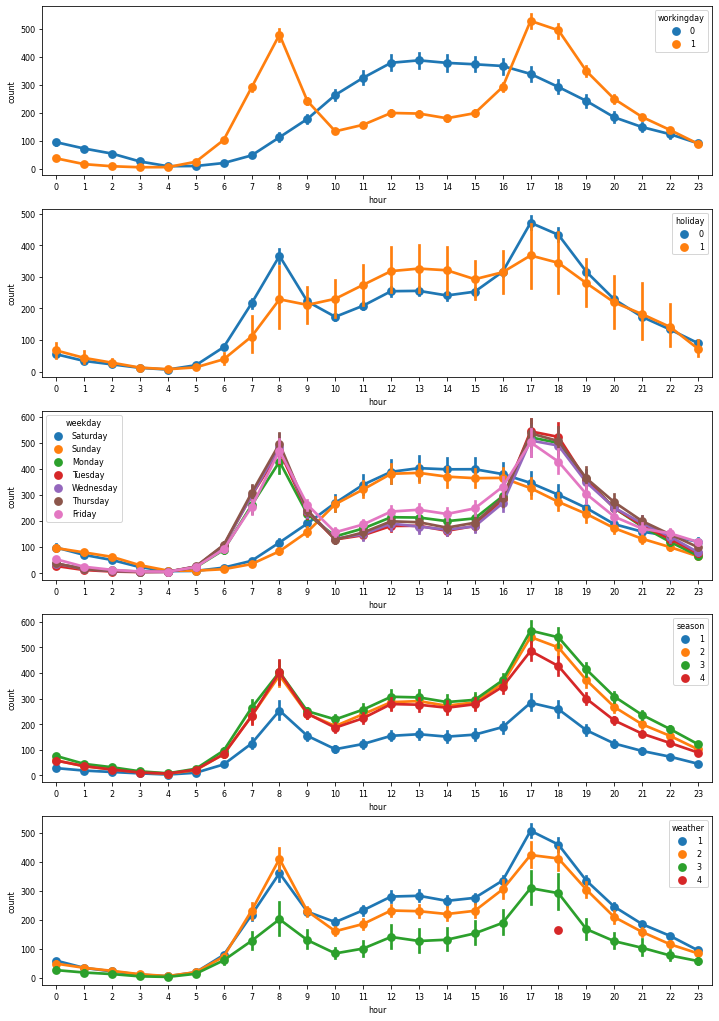

In [32]:
fig, ax = plt.subplots(nrows = 5)
fig.set_size_inches(12, 18)

sns.pointplot(x = 'hour', y = 'count', hue = 'workingday', data = temp_train, ax = ax[0])
sns.pointplot(x = 'hour', y = 'count', hue = 'holiday', data = temp_train, ax = ax[1])
sns.pointplot(x = 'hour', y = 'count', hue = 'weekday', data = temp_train, ax = ax[2])
sns.pointplot(x = 'hour', y = 'count', hue = 'season', data = temp_train, ax = ax[3])
sns.pointplot(x = 'hour', y = 'count', hue = 'weather', data = temp_train, ax = ax[4])

plt.show()

### 3.시각화의 결론
- causal과 registered의 합계가 target값(count)이므로 비례관계가 성립하기에 제거한다. 
- 수치형 변수
 + 온도(temp,atemp)는 정비례 관계가 습도(humidity)는 반비례 관계가 나타나며 풍향(windspeed)는 정비례관계가 너무 작기에 제거(또는 0의 값 보완)한다.
- 범주형 변수
 + 시간 변수는 다른 변수들과의 대여량 간 관계를 설명해주는 강력한 변수이다
 + 날씨(weather)는 값이 4인 것은 이상치 이므로 제거한다.
 + 계절(season)은 달(month)와 같은 변수에서 나왔기에 단순한 계절(season)만 남긴다.
- 타깃(target)
 + count

## STEP5. 데이터 전처리
- datetime으로부터 필요한 열 생성 : hour, dayofweek(month나 day는 의미없다)
- causal과 registered 컬럼 제거
- weather의 4인 값 제거
- windspeed의 변수 보완
- count의 아웃라이어 제거(3시그마를 초과하는 값을 이상치로 간주하고 제거)
- atemp제거(temp와 별차이가 없다)
- target인 count의 열 로그변환

In [33]:
# datetime으로부터 필요한 열 생성 : hour, dayofweek(month나 day는 의미없다)
train['date'] = pd.to_datetime(train['datetime'])
train['year'] = train['date'].dt.year
train['hour'] = train['date'].dt.hour
train['dayofweek'] = train['date'].dt.dayofweek
# 불필요한 열 삭제
del train ['datetime']


In [34]:
del train ['date']
display(train.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,4,5


In [35]:
# causal과 registered 컬럼 제거
train = train.drop(['casual','registered'],axis = 1)
train.shape, test.shape

((10886, 12), (6493, 9))

In [36]:
#1 weather 4값 제거
train = train[train['weather']!=4].reset_index(drop = True)
train.shape, test.shape# test값을 건딜면 제출이 안되니 그냥 보존

((10885, 12), (6493, 9))

In [37]:
# count의 아웃라이어 제거(3시그마를 초과하는 값을 이상치로 간주하고 제거)
train = train[train['count'] - train['count'].mean()< 3*train['count'].std()]
train.reset_index(inplace = True, drop = True)
print(train.shape)


(10738, 12)


In [38]:
# target인 count열의 로그변환
train['count'] = np.log1p(train['count'])
display(train.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.833213,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.713572,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2.639057,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.693147,2011,4,5


In [39]:
# 왜도확인 -> +-2범위에 들어가므로 치우침이 없다.
print(train['count'].skew())

-0.8704448527723871


In [40]:
# 범주형 변수의 타입변환
cate_name = ['weather','season','year','hour','dayofweek']

for c in cate_name:
    train[c] = train[c].astype('category')
train.dtypes

season        category
holiday          int64
workingday       int64
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count          float64
year          category
hour          category
dayofweek     category
dtype: object

In [41]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10738 entries, 0 to 10737
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10738 non-null  category
 1   holiday     10738 non-null  int64   
 2   workingday  10738 non-null  int64   
 3   weather     10738 non-null  category
 4   temp        10738 non-null  float64 
 5   atemp       10738 non-null  float64 
 6   humidity    10738 non-null  int64   
 7   windspeed   10738 non-null  float64 
 8   count       10738 non-null  float64 
 9   year        10738 non-null  category
 10  hour        10738 non-null  category
 11  dayofweek   10738 non-null  category
dtypes: category(5), float64(4), int64(3)
memory usage: 641.3 KB
None


- test 데이터도 train 데이터와 동일한 작업을 해준다

In [42]:
# datetime으로부터 필요한 열 생성 : hour, dayofweek(month나 day는 의미없다)
test['date'] = pd.to_datetime(test['datetime'])
test['year'] = test['date'].dt.year
test['hour'] = test['date'].dt.hour
test['dayofweek'] = test['date'].dt.dayofweek
#불필요한 열 삭제
del test ['datetime']
del test ['date']
display(test.head())



,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,4,3


In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   year        6493 non-null   int64  
 9   hour        6493 non-null   int64  
 10  dayofweek   6493 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 558.1 KB


In [44]:
#1 weather 4값 제거
#test = test[test['weather']!=4].reset_index(drop = True)
#test.shape# test값을 건딜면 제출이 안되니 그냥 보존

In [45]:
# 범주형 변수의 타입변환
cate_name1 = ['weather','season','year','hour','dayofweek']

for c in cate_name1:
    test[c] = test[c].astype('category')
test.dtypes

season        category
holiday          int64
workingday       int64
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
hour          category
dayofweek     category
dtype: object

In [46]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   int64   
 2   workingday  6493 non-null   int64   
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   year        6493 non-null   category
 9   hour        6493 non-null   category
 10  dayofweek   6493 non-null   category
dtypes: category(5), float64(3), int64(3)
memory usage: 337.8 KB
None


## STEP 6.모델링

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

### 예측모델
- 변수와 타겟값을 나눠 X,y 데이터를 만든다. 

In [48]:
X = train.drop(['count'],axis = 1)
y = train['count']

- 수치형 변수인 temp,atemp,humidity,windspeed에 스케일링을 한다.

In [49]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
from sklearn.preprocessing import MinMaxScaler

In [50]:
# 선형회귀모델
lr_reg = LinearRegression()
# 피처에 대한 표준화 진행과 K-fold를 함께 진행
pipe = make_pipeline(MinMaxScaler(),lr_reg)
scores = cross_validate(pipe,X,y,cv=5,
                        scoring='neg_mean_squared_error',return_train_score =True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score'])))

MSLE: 1.056


In [51]:
#rf
np.random.seed(0)
rf = RandomForestRegressor(n_estimators = 300)
# 피처에 대한 표준화 진행과 K-fold를 함께 진행
pipe = make_pipeline(MinMaxScaler(),rf)
scores = cross_validate(pipe,X,y,cv=5,
                        scoring='neg_mean_squared_error',return_train_score =True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score'])))

MSLE: 0.225


In [52]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')
# 피처에 대한 표준화 진행과 K-fold를 함께 진행
pipe = make_pipeline(MinMaxScaler(),lgbm)
scores = cross_validate(pipe,X,y,cv=5,
                        scoring='neg_mean_squared_error',return_train_score =True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score'])))

MSLE: 0.183


In [53]:
# 피쳐 표준화
minmax = MinMaxScaler()
minmax.fit(X) # 훈련셋 모수 분포 저장
X_scaled = minmax.transform(X)
X_test_scaled = minmax.transform(test)

# 최종파라미터 튜닝된 모델로 학습
lgbm = LGBMRegressor(n_estimators = 300, objective = 'regression',
                     learning_rate = 0.1, max_depth = 3, reg_lambda =1 ,subsample = 0.5, 
                     random_state = 99)

# 학습
lgbm.fit(X_scaled, y)

LGBMRegressor(max_depth=3, n_estimators=300, objective='regression',
              random_state=99, reg_lambda=1, subsample=0.5)

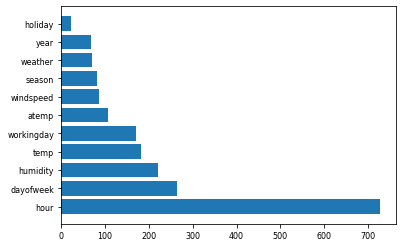

In [54]:
# test에 대한 예측
pred = lgbm.predict(X_test_scaled)
fpred = np.expm1(pred)# 로그변환을 풀어줌

#lgbm 모델의 feature importance
imp = pd.DataFrame({'feature': test.columns,
                   'coefficient':lgbm.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp['feature'],imp['coefficient'])
plt.show()


- 피처의 중요도를 뽑아봤을때 역시 hour가 가장 높은 기여도로 나왔다.

## STEP7. 제출

In [55]:
del submission['count']
submission['count'] =fpred

submission.to_csv('submission.csv',index=False)

In [56]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,8.674224
1,2011-01-20 01:00:00,4.650374
2,2011-01-20 02:00:00,2.842267
3,2011-01-20 03:00:00,1.616020
4,2011-01-20 04:00:00,1.506303
